In [465]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from sklearn.model_selection import train_test_split

In [517]:
df=pd.read_csv('dataset2.csv')

In [518]:
df.rename(columns = {'Company\xa0\n(Maker-if known)':'Company', 'Specific Bean Origin\nor Bar Name':'Region', 
                              'Review\nDate':'Date','Cocoa\nPercent':'Cocoa','Company\nLocation':'Location',
                              'Bean\nType':'Type','Broad Bean\nOrigin':'Origin'}, inplace = True) 

In [519]:
df=df.dropna()

In [520]:
df['Cocoa'] = df['Cocoa'].map(lambda x: x.rstrip('%'))

In [521]:
df['Cocoa']=df['Cocoa'].astype(float)

In [522]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1793 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Company   1793 non-null   object 
 1   Region    1793 non-null   object 
 2   REF       1793 non-null   int64  
 3   Date      1793 non-null   int64  
 4   Cocoa     1793 non-null   float64
 5   Location  1793 non-null   object 
 6   Rating    1793 non-null   float64
 7   Type      1793 non-null   object 
 8   Origin    1793 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 140.1+ KB


In [523]:
rate4=df[df['Rating']>=4]
top_beans=rate4["Origin"].value_counts().head(15)
top_beans

Venezuela           21
Madagascar          12
Peru                12
Ecuador              9
Papua New Guinea     5
Colombia             3
                     3
Mexico               3
Bolivia              3
Brazil               3
Haiti                2
Costa Rica           2
Ghana                2
Guatemala            2
Jamaica              2
Name: Origin, dtype: int64

In [524]:
top_beans.sum()/len(rate4)

0.8484848484848485

In [525]:
rate3=df[df['Rating']>=3]
top_beans1=rate3["Origin"].value_counts().head(15)
top_beans1

Venezuela             166
Ecuador               138
Madagascar            117
Dominican Republic    113
Peru                  111
Brazil                 48
                       47
Nicaragua              45
Bolivia                45
Belize                 43
Papua New Guinea       35
Vietnam                34
Colombia               31
Costa Rica             29
Tanzania               26
Name: Origin, dtype: int64

In [526]:
top_beans1.sum()/len(rate3)

0.7643122676579925

Clearly Venezuela is the place where Best Cocoa beans are grown.


In [527]:
top_beans2=rate4["Location"].value_counts().head(15)
top_beans2

U.S.A.         25
France         23
Italy           9
Canada          9
Belgium         6
Switzerland     6
U.K.            4
Australia       4
Spain           3
Ecuador         3
Scotland        1
Guatemala       1
Madagascar      1
Brazil          1
Sao Tome        1
Name: Location, dtype: int64

In [528]:
top_beans2.sum()/len(rate4)

0.9797979797979798

In [529]:
top_beans3=rate3["Location"].value_counts().head(15)
top_beans3

U.S.A.         560
France         121
Canada         104
U.K.            58
Italy           56
Australia       41
Ecuador         34
Switzerland     33
Germany         29
Belgium         29
Austria         22
Spain           20
Hungary         17
Colombia        17
Brazil          15
Name: Location, dtype: int64

In [530]:
top_beans3.sum()/len(rate3)

0.8594795539033457

USA produces the highest rated bars.

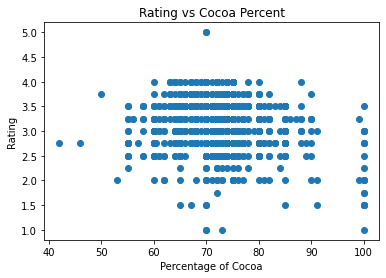

In [531]:
import matplotlib.pyplot as plt

plt.scatter(df['Cocoa'], df['Rating'])
plt.title('Rating vs Cocoa Percent')
plt.xlabel('Percentage of Cocoa')
plt.ylabel('Rating')
plt.show()

In [532]:
df['Rating'] = df['Rating'].round().astype(int)

In [533]:
def cat_column(feature_name, vocab):
  return tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab)

In [534]:
feature_columns = []

EMBEDDING_COLUMNS=['Company','Region','Location','Type','Origin']
NUMERIC_COLUMNS = ['Cocoa','REF','Date']

for feature_name in EMBEDDING_COLUMNS:
  vocabulary = df[feature_name].unique()
  feature_columns.append(tf.feature_column.embedding_column(cat_column(feature_name, vocabulary), dimension=8))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))  

In [537]:
train, test = train_test_split(df, test_size=0.2)

In [538]:
y_train = train.pop('Rating')
y_test = test.pop('Rating')

In [539]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    dataset = dataset.repeat(n_epochs)
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

train_input_fn = make_input_fn(train, y_train)
eval_input_fn = make_input_fn(test, y_test, shuffle=False, n_epochs=1)

In [542]:
est = tf.estimator.DNNClassifier(feature_columns=feature_columns,hidden_units=[512,128,128],n_classes=7)
est.train(train_input_fn,steps=3000)
result = est.evaluate(eval_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpiujwwcxi', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. 

In [543]:
print(result)

{'accuracy': 0.53481895, 'average_loss': 0.9530292, 'loss': 0.9530292, 'global_step': 3000}
